# TensorFlowでDCGAN

tensorflow 2.xを使う。

In [1]:
%tensorflow_version 2.x

ライブラリのインポート

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.datasets import mnist

データの読み込み

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

11501568/11490434 [==============================] - 0s 0us/step


Generatorの定義

In [4]:
latent_dim = 64

generator = models.Sequential()
generator.add(
  layers.Dense(7*7*128, kernel_initializer=initializers.TruncatedNormal(),
               input_shape=(latent_dim,), name='expand'))
generator.add(layers.LeakyReLU(name='leaky_relu1'))
generator.add(layers.Reshape((7, 7, 128), name='reshape'))
generator.add(
  layers.Conv2DTranspose(64, 5, strides=2, padding='same',
                         kernel_initializer=initializers.TruncatedNormal(),
                         name='deconv1'))
generator.add(layers.LeakyReLU(name='leaky_relu2'))
generator.add(
  layers.Conv2DTranspose(1, 5, strides=2, padding='same',
                         kernel_initializer=initializers.TruncatedNormal(),
                         activation='sigmoid', name='deconv2'))
generator.add(layers.Flatten(name='flatten'))
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand (Dense)               (None, 6272)              407680    
_________________________________________________________________
leaky_relu1 (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
deconv1 (Conv2DTranspose)    (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_relu2 (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
deconv2 (Conv2DTranspose)    (None, 28, 28, 1)         1601      
_________________________________________________________________
flatten (Flatten)            (None, 784)               0

Disriminatorの定義

In [5]:
discriminator = models.Sequential()
discriminator.add(layers.Reshape((28, 28, 1), input_shape=((28*28,)),
                                 name='reshape'))
discriminator.add(
  layers.Conv2D(64, (5, 5), strides=2, padding='same',
                kernel_initializer=initializers.TruncatedNormal(),
                name='conv1'))
discriminator.add(layers.LeakyReLU(name='leaky_relu1'))
discriminator.add(
  layers.Conv2D(128, (5, 5), strides=2, padding='same',
                kernel_initializer=initializers.TruncatedNormal(),
                name='conv2'))
discriminator.add(layers.LeakyReLU(name='leaky_relu2'))
discriminator.add(layers.Flatten(name='flatten'))
discriminator.add(layers.Dropout(rate=0.4, name='dropout'))
discriminator.add(layers.Dense(1, activation='sigmoid', name='sigmoid'))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_relu1 (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_relu2 (LeakyReLU)      (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6272)             

Discriminatorのコンパイル

In [6]:
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

GANモデルの定義

In [7]:
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan_model = models.Model(gan_input, gan_output)
gan_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               614145    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 827,010
Trainable params: 614,145
Non-trainable params: 212,865
_________________________________________________________________


GANモデルのコンパイル

In [8]:
gan_model.compile(optimizer='adam', loss='binary_crossentropy')

パラメータの定義

In [9]:
batch_size = 32
image_num = 0
step = 0
examples = []
sample_inputs = np.random.rand(8, latent_dim) * 2.0 - 1.0
examples.append(generator.predict(sample_inputs))

学習

In [10]:
for _ in range(40000):
    random_inputs = np.random.rand(batch_size, latent_dim) * 2.0 - 1.0
    generated_images = generator.predict(random_inputs)
    real_images = train_images[image_num : image_num+batch_size]
    all_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.zeros((batch_size, 1)),
                             np.ones((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    d_loss = discriminator.train_on_batch(all_images, labels)

    random_inputs = np.random.rand(batch_size, latent_dim) * 2.0 - 1.0
    fake_labels = np.ones((batch_size, 1))
    g_loss = gan_model.train_on_batch(random_inputs, fake_labels)

    image_num += batch_size
    if image_num + batch_size > len(train_images):
        image_num = 0

    step += 1
    if step % 4000 == 0:
        print('step: {}, loss(discriminator, generator): {:6.4f}, {:6.4f}'.format(
              step, d_loss, g_loss))
        examples.append(generator.predict(sample_inputs))

step: 4000, loss(discriminator, generator): 0.7903, 0.9576
step: 8000, loss(discriminator, generator): 0.5748, 0.9605
step: 12000, loss(discriminator, generator): 0.8035, 1.2576
step: 16000, loss(discriminator, generator): 0.5979, 1.4210
step: 20000, loss(discriminator, generator): 0.4977, 1.4651
step: 24000, loss(discriminator, generator): 0.4930, 1.3368
step: 28000, loss(discriminator, generator): 0.4955, 1.8421
step: 32000, loss(discriminator, generator): 0.5193, 1.6428
step: 36000, loss(discriminator, generator): 0.5259, 1.2012
step: 40000, loss(discriminator, generator): 0.4141, 1.3880


学習結果

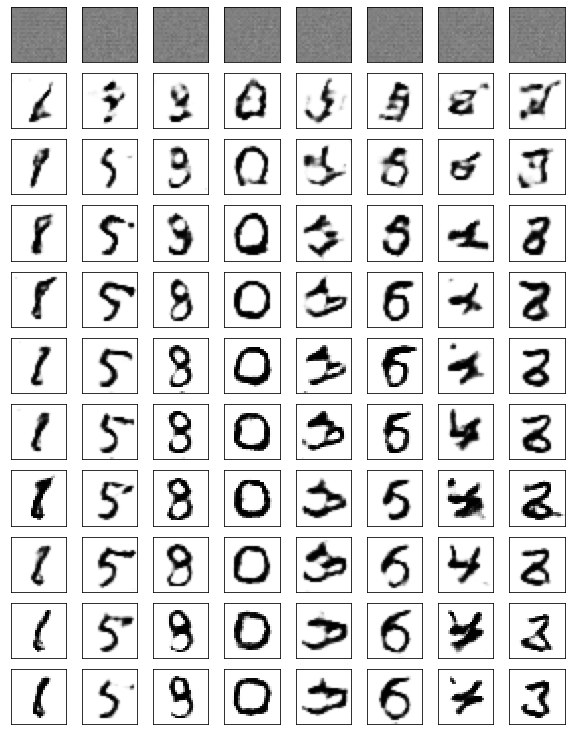

In [11]:
def show_images(examples):
    fig = plt.figure(figsize=(10, 1.2*len(examples)))
    c = 1
    for images in examples:
        for image in images:
            subplot = fig.add_subplot(len(examples), 8, c)
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.imshow(image.reshape((28, 28)),
                           vmin=0, vmax=1, cmap=plt.cm.gray_r)
            c += 1

show_images(examples)